<a href="https://colab.research.google.com/github/KoreTane/Preparing-ML/blob/main/CSB_Dance_Data_wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install xlsxwriter
#!pip install pandas-profiling==3.3.0
#!pip install fuzzywuzzy
#!pip install tabula-py

In [2]:
import pandas as pd  # Manipulação de dados em formato de tabela
import numpy as np  # Para operações numéricas
from scipy import stats  # Para estatística e análise de dados
import xlsxwriter  # Criar e manipular arquivos Excel
import matplotlib.pyplot as plt  # Biblioteca para criação de gráficos
import seaborn as sns  # Biblioteca para visualização de dados
from scipy.stats import chi2_contingency  # Função para calcular a estatística de qui-quadrado
import math  # Operações matemáticas
from pandas_profiling import ProfileReport  # Biblioteca para geração de relatórios de perfil de dados
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import tabula
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/usr/local/lib/python3.10/dist-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove th

In [3]:
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [4]:
df = pd.read_excel('CBS_CRM.xlsx', skiprows=1)

In [5]:
# Definir tema global para os gráficos
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8)
    }
)

In [6]:
# Listar os atributos e funções de um objeto, excluindo os que começam com _
def list_attributes(obj):
  return [attr for attr in obj.__dir__() if not attr.startswith('_')]

<h1><font size="5" color="#FF69B4">Exploração e tratamento de dados</font></h1>

<p><font size="4">Nesta seção, vamos explorar e tratar os dados para prepará-los para a análise. Isso inclui:

* Visualização dos dados para entender a distribuição e a estrutura
* Tratamento de valores ausentes e outliers
* Transformação de variáveis para melhorar a análise.</font></p>

In [7]:
df.drop('Unnamed: 15', axis=1, inplace=True)

In [8]:
# Fornece uma visão geral rápida e fácil de entender dos dados, incluindo informações sobre valores ausentes, registros duplicados, variáveis categóricas e numéricas, correlações e histogramas.
#df.profile_report()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674 entries, 0 to 1673
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   QTDE              204 non-null    float64       
 1   DATA 1º CONTATO   1672 non-null   object        
 2   NOME COMPLETO     1670 non-null   object        
 3   IDADE             1428 non-null   object        
 4   TELEFONE          1591 non-null   object        
 5   STATUS            1668 non-null   object        
 6   VIA               1668 non-null   object        
 7   ESTILOS           1664 non-null   object        
 8   DATA AGENDAMENTO  223 non-null    datetime64[ns]
 9   HORÁRIO           1301 non-null   object        
 10  PROFESSOR         1373 non-null   object        
 11  COMPARECEU        1650 non-null   object        
 12  REAGENDAMENTO     37 non-null     object        
 13  SITUAÇÃO          1640 non-null   object        
 14  OBSERVAÇÕES       838 no

In [10]:
# Identificar e mostrar valores nulos
df_missing = (
  df.isna().sum()
  .to_frame('missing_count')
  .join((df.isna().sum() / df.shape[0]).to_frame('missing_pct'))# shape retorna tupla, com quantidade de linha e colunas
  .sort_values('missing_count', ascending=False)
)
# Formatando para duas casas decimais (convertendo em porcentagem, normal seria 2f)
df_missing.style.format('{:.2%}', subset=['missing_pct'])
# Somente formatando o missing_pct

,missing_count,missing_pct
REAGENDAMENTO,1637,97.79%
QTDE,1470,87.81%
DATA AGENDAMENTO,1451,86.68%
OBSERVAÇÕES,836,49.94%
HORÁRIO,373,22.28%
PROFESSOR,301,17.98%
IDADE,246,14.70%
TELEFONE,83,4.96%
SITUAÇÃO,34,2.03%
COMPARECEU,24,1.43%


In [11]:
df.head(5)

,QTDE,DATA 1º CONTATO,NOME COMPLETO,IDADE,TELEFONE,STATUS,VIA,ESTILOS,DATA AGENDAMENTO,HORÁRIO,PROFESSOR,COMPARECEU,REAGENDAMENTO,SITUAÇÃO,OBSERVAÇÕES
0,1.0,2022-01-07 00:00:00,Graziele,22,12 99614-0592,AULA EXPERIMENTAL,WHATSAPP,JAZZ FUNK,NaT,18h30,ALISSON,SIM,NaN,MATRICULADO,NaN
1,2.0,2022-01-07 00:00:00,Camila,ADULTO,11 94129-6714,INFORMAÇÕES,WHATSAPP,JAZZ,NaT,19H30,LIA,NÃO,NaN,SEMANA SOLIDÁRIA,NaN
2,3.0,2021-01-05 00:00:00,MAIARA GOUVEA,16,98841-5432,AULA EXPERIMENTAL,WHATS,K-POP,NaT,19H00,ALISSON,NÃO FICOU,NaN,NÃO RESPONDE,NaN
3,4.0,2021-01-05 00:00:00,ENIALE RAMOS QUINTINO (MÃE ELAINE),11,99124-9509,AULA EXPERIMENTAL,WHATS,JAZZ,NaT,17H00,LIA,MATRICULADO,NaN,MATRICULADO,NaN
4,5.0,2022-01-07 00:00:00,Bia,ADULTO,12 98129-7939,INFORMAÇÕES,WHATSAPP,MODALIDADES,NaT,-,-,NÃO,NaN,SEMANA SOLIDÁRIA,NaN


In [12]:
#Converter em string para alterações
df['DATA 1º CONTATO'] = df['DATA 1º CONTATO'].astype(str)

In [13]:
 # Dropar nulos
df.dropna(subset=['DATA 1º CONTATO'], inplace=True)

In [14]:
# Corrigir valores que não estão no formato
df = df[df['DATA 1º CONTATO'].astype(str).str.replace(' |-', '', regex=True).ne('')]

In [15]:
# Corrigir inconsistencias
df['DATA 1º CONTATO'] = df['DATA 1º CONTATO'].str.replace('223', '2023').str.replace('2012', '2021')

In [16]:
# Dropar nulos
df = df[pd.to_datetime(df['DATA 1º CONTATO'], errors='coerce').notna()]
# Converter em formato date
df['DATA 1º CONTATO'] = pd.to_datetime(df['DATA 1º CONTATO'], errors='coerce').dt.date

<ipython-input-16-7d9805f7015f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATA 1º CONTATO'] = pd.to_datetime(df['DATA 1º CONTATO'], errors='coerce').dt.date


In [17]:
# Excluir valores nulos
df.dropna(subset=['NOME COMPLETO'], inplace=True)
# Remover caracteres especiais
df['NOME COMPLETO'] = df['NOME COMPLETO'].str.replace(r'[^\w\s]', '', regex=True)
df['NOME COMPLETO'] = df['NOME COMPLETO'].str.strip()
df['NOME COMPLETO'] = df['NOME COMPLETO'].str.upper()

<ipython-input-17-8c57adc71785>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['NOME COMPLETO'], inplace=True)
<ipython-input-17-8c57adc71785>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NOME COMPLETO'] = df['NOME COMPLETO'].str.replace(r'[^\w\s]', '', regex=True)
<ipython-input-17-8c57adc71785>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [18]:
# Converte a coluna idade para numerico
df['IDADE'] = pd.to_numeric(df['IDADE'], errors='coerce')

<ipython-input-18-88bf9c4f13f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IDADE'] = pd.to_numeric(df['IDADE'], errors='coerce')


In [19]:
# Converter valores numéricos e '%-%' para float, e strings para NaN
df['IDADE'] = df['IDADE'].apply(lambda x: float(x) if isinstance(x, (int, float)) else
                                      (float(x.split('-')) if isinstance(x, str) and '-' in x else np.nan))

# Preencher valores NaN com a média da coluna
df['IDADE'].fillna(df['IDADE'].mean(), inplace=True)

# Alterar para tipo inteiro
df['IDADE'] = df['IDADE'].astype(int)

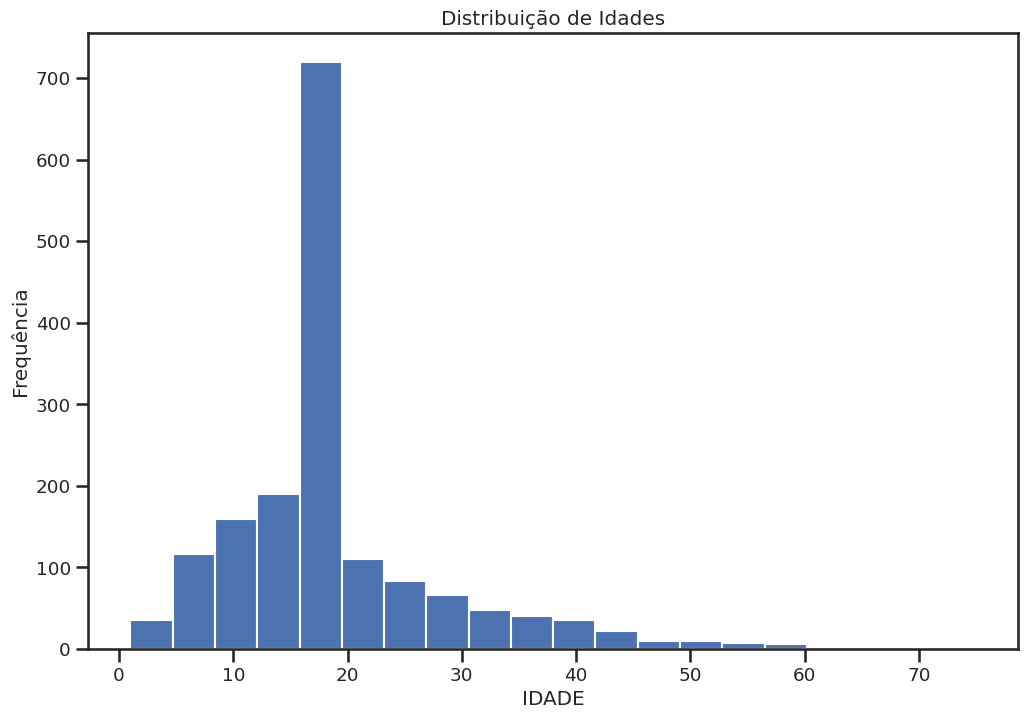

In [20]:
# Análise de distribuição de valores em 'IDADE' para verificar outliers
plt.hist(df['IDADE'], bins=20)
plt.xlabel('IDADE')
plt.ylabel('Frequência')
plt.title('Distribuição de Idades')
plt.show()

In [21]:
# Criar a coluna 'FAIXA ETARIA'
df['FAIXA ETARIA'] = df['IDADE'].apply(lambda x:
    'CRIANÇA' if x < 10 else
    'ADOLESCENTE' if x <= 15 else
    'ADULTO'
)

In [22]:
# Reordena as colunas
df = df[['DATA 1º CONTATO', 'NOME COMPLETO', 'IDADE', 'FAIXA ETARIA', 'TELEFONE', 'STATUS', 'VIA', 'ESTILOS', 'DATA AGENDAMENTO', 'HORÁRIO', 'PROFESSOR', 'COMPARECEU', 'REAGENDAMENTO', 'SITUAÇÃO', 'OBSERVAÇÕES']]

In [23]:
df.head()

,DATA 1º CONTATO,NOME COMPLETO,IDADE,FAIXA ETARIA,TELEFONE,STATUS,VIA,ESTILOS,DATA AGENDAMENTO,HORÁRIO,PROFESSOR,COMPARECEU,REAGENDAMENTO,SITUAÇÃO,OBSERVAÇÕES
0,2022-01-07,GRAZIELE,22,ADULTO,12 99614-0592,AULA EXPERIMENTAL,WHATSAPP,JAZZ FUNK,NaT,18h30,ALISSON,SIM,NaN,MATRICULADO,NaN
1,2022-01-07,CAMILA,19,ADULTO,11 94129-6714,INFORMAÇÕES,WHATSAPP,JAZZ,NaT,19H30,LIA,NÃO,NaN,SEMANA SOLIDÁRIA,NaN
2,2021-01-05,MAIARA GOUVEA,16,ADULTO,98841-5432,AULA EXPERIMENTAL,WHATS,K-POP,NaT,19H00,ALISSON,NÃO FICOU,NaN,NÃO RESPONDE,NaN
3,2021-01-05,ENIALE RAMOS QUINTINO MÃE ELAINE,11,ADOLESCENTE,99124-9509,AULA EXPERIMENTAL,WHATS,JAZZ,NaT,17H00,LIA,MATRICULADO,NaN,MATRICULADO,NaN
4,2022-01-07,BIA,19,ADULTO,12 98129-7939,INFORMAÇÕES,WHATSAPP,MODALIDADES,NaT,-,-,NÃO,NaN,SEMANA SOLIDÁRIA,NaN


In [24]:
# desnecessário aparecer no modelo (até poderiamos utilizar engenharia de recursos para ter uma ideia sobre a origem da pessoa pelo DDD, mas não é relevante neste caso pois possuimos o cadastro do aluno)
df['TELEFONE'] = df['TELEFONE'].apply(lambda x: '0000-0000')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1668 entries, 0 to 1673
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATA 1º CONTATO   1668 non-null   object        
 1   NOME COMPLETO     1668 non-null   object        
 2   IDADE             1668 non-null   int64         
 3   FAIXA ETARIA      1668 non-null   object        
 4   TELEFONE          1668 non-null   object        
 5   STATUS            1666 non-null   object        
 6   VIA               1666 non-null   object        
 7   ESTILOS           1662 non-null   object        
 8   DATA AGENDAMENTO  222 non-null    datetime64[ns]
 9   HORÁRIO           1298 non-null   object        
 10  PROFESSOR         1371 non-null   object        
 11  COMPARECEU        1648 non-null   object        
 12  REAGENDAMENTO     37 non-null     object        
 13  SITUAÇÃO          1637 non-null   object        
 14  OBSERVAÇÕES       838 no

In [26]:
df['STATUS'].unique()

array(['AULA EXPERIMENTAL', 'INFORMAÇÕES', 'AULA ESPERIMENTAL',
       'INFORMAÇÕES ', 'CAPTAÇÃO', 'COREOGRAFIA', 'AULA AVULSA',
       'INFORMACOES', 'INFORMAÇÃO', 'INFORMAÇOES', nan], dtype=object)

In [27]:
# Padronizar 'INFORMAÇÕES'
df['STATUS'] = df['STATUS'].str.replace('INFORMAÇÕES ', 'INFORMAÇÕES')
df['STATUS'] = df['STATUS'].str.replace('INFORMACOES', 'INFORMAÇÕES')
df['STATUS'] = df['STATUS'].str.replace('INFORMAÇÃO', 'INFORMAÇÕES')
df['STATUS'] = df['STATUS'].str.replace('INFORMAÇOES', 'INFORMAÇÕES')
df['STATUS'] = df['STATUS'].str.replace('INFORMAÇÕES', 'CAPTAÇÃO')
# Substituir 'AULA AVULSA' por 'EXPERIMENTAL'
df['STATUS'] = df['STATUS'].str.replace('AULA AVULSA', 'EXPERIMENTAL')
df['STATUS'] = df['STATUS'].str.replace('AULA EXPERIMENTAL', 'EXPERIMENTAL')

# Padronizar 'AULA ESPERIMENTAL'
df['STATUS'] = df['STATUS'].str.replace('AULA ESPERIMENTAL', 'EXPERIMENTAL')
df['STATUS'] = df['STATUS'].str.replace('AULA AULA EXPERIMENTAL', 'EXPERIMENTAL')
df['STATUS'] = df['STATUS'].str.replace('COREOGRAFIA', 'EXPERIMENTAL')


# Excluir nulos
df = df.dropna(subset=['STATUS'])

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1673
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATA 1º CONTATO   1666 non-null   object        
 1   NOME COMPLETO     1666 non-null   object        
 2   IDADE             1666 non-null   int64         
 3   FAIXA ETARIA      1666 non-null   object        
 4   TELEFONE          1666 non-null   object        
 5   STATUS            1666 non-null   object        
 6   VIA               1666 non-null   object        
 7   ESTILOS           1662 non-null   object        
 8   DATA AGENDAMENTO  222 non-null    datetime64[ns]
 9   HORÁRIO           1298 non-null   object        
 10  PROFESSOR         1371 non-null   object        
 11  COMPARECEU        1648 non-null   object        
 12  REAGENDAMENTO     37 non-null     object        
 13  SITUAÇÃO          1637 non-null   object        
 14  OBSERVAÇÕES       838 no

In [29]:
df['VIA'].unique()

array(['WHATSAPP', 'WHATS', 'INSTAGRAM', 'TELEFONE', 'PESSOALMENTE',
       'PRESENCIAL', 'PRESENCIAL ', 'SITE', 'VALE AULA', 'FACEBOOK',
       'MESSENGER', 'MAE JÁ É ALUNA', 'ALUNA'], dtype=object)

In [30]:
df['VIA'] = df['VIA'].str.replace('WHATSAPPAPP', 'WHATSAPP')
df['VIA'] = df['VIA'].str.replace('WHATSAPP', 'WHATSAPP')
df['VIA'] = df['VIA'].str.replace('PESSOALMENTE', 'PRESENCIAL')
df['VIA'] = df['VIA'].str.replace('VALE ', 'PRESENCIAL')
df['VIA'] = df['VIA'].str.replace('MAE JÁ É ALUNA', 'PRESENCIAL')
df['VIA'] = df['VIA'].str.replace('ALUNA', 'PRESENCIAL')
df['VIA'] = df['VIA'].str.replace('MESSENGER', 'FACEBOOK')
df['VIA'] = df['VIA'].str.replace('PRESENCIALAULA', 'PRESENCIAL')
df['VIA'] = df['VIA'].str.replace('PRESENCIAL ', 'PRESENCIAL')

In [31]:
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZ FUNK ', 'JAZZ FUNK')
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZ FUNKINICIANTE', 'JAZZ FUNK')
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZ FUNKINTERMEDIARIO', 'JAZZ FUNK')
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZFUNK', 'JAZZ FUNK')

df['ESTILOS'] = df['ESTILOS'].replace(r'Jazz', 'JAZZ', regex=True)
df['ESTILOS'] = df['ESTILOS'].replace(r'JAZZ iniciante', 'JAZZ INICIANTE', regex=True)
df['ESTILOS'] = df['ESTILOS'].replace(r'JAZZ INICIANTES', 'JAZZ INICIANTE', regex=True)

df['ESTILOS'] = df['ESTILOS'].str.replace('AULA DE BREAK', 'DANÇAS URBANAS')
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZE D URBANAS', 'DANÇAS URBANAS')

df['ESTILOS'] = df['ESTILOS'].str.replace(r'[^\w\s]+', '', regex=True).str.replace('\s+', ' ', regex=True).str.strip()
df['ESTILOS'] = df['ESTILOS'].str.replace(r'BALLET.*|KPOPBALLET.*|BALLEYT', 'BALLET CLÁSSICO', regex=True)

df['ESTILOS'] = df['ESTILOS'].str.replace(r'KPOP.*|K POP INTERMEDIARIO|K POP INICIANTE|kpop|K Pop|Kpop|K POP', 'K-POP', regex=True)

df['ESTILOS'] = df['ESTILOS'].str.replace(r'SAPATEADO.*|Sapateado', 'SAPATEADO', regex=True)

df['ESTILOS'] = df['ESTILOS'].str.replace(r'CONTEMPORANEO.*', 'CONTEMPORÂNEO', regex=True)

In [32]:
# Contar a frequência de cada valor em ESTILO
value_counts = df['ESTILOS'].value_counts()

In [33]:
# Selecionar os 3 valores mais frequentes
top_3_values = value_counts.nlargest(3).index.tolist()

In [34]:
top_3_values

['DANÇAS URBANAS', 'JAZZ FUNK', 'JAZZ']

In [35]:
# Padronizar os valores que não são "JAZZFUNK", "JAZZ", "K-POP", "SAPATEADO", "DANÇAS URBANAS", "CONTEMPORÂNEO" e "BALLET CLÁSSICO"
# e distribuir igualitariamente entre estes os 3 valores que mais aparecem
df['ESTILOS'] = np.where(df['ESTILOS'].isin(['JAZZFUNK', 'JAZZ', 'K-POP', 'SAPATEADO', 'DANÇAS URBANAS', 'CONTEMPORÂNEO', 'BALLET CLÁSSICO']),
                        df['ESTILOS'],
                        np.random.choice(top_3_values))

In [36]:
df['DATA AGENDAMENTO'] = df['DATA AGENDAMENTO'].astype(str)

In [37]:
# Preencher os valores vazios com "Não agendou"
df['DATA AGENDAMENTO'].fillna('Não agendou', inplace=True)


# Alterar o ano de 2032 para 2023
df['DATA AGENDAMENTO'] = df['DATA AGENDAMENTO'].apply(lambda x: '2023-' + x[5:] if x and x.startswith('2032') else x)

In [38]:
# Renomear a coluna HORÁRIO para TURNO
df = df.rename(columns={'HORÁRIO': 'TURNO'})

In [39]:
df['TURNO_FIRST_TWO_DIGITS'] = df['TURNO'].apply(lambda x: x[:2] if isinstance(x, str) else str(x) if not pd.isnull(x) else '')

In [40]:
df['TURNO'].unique()

array(['18h30', '19H30', '19H00', '17H00', '-', '20H00', '18H00', '16H00',
       '16H30', '21H00', '20H30', 'NOITE', '15H00', '17H30', 'TARDE',
       '16h30', '18h00', nan, 'MANHÃ', '19HOO', '19h00', '19h30', '17h30',
       '18H30', '16h00', '15H30', '15h40', '17h00', '14H30', '15h', '18H',
       'SÁBADO', '17h', '18h', '15H', '17H45', '18H45', '20h30', '8h00',
       '9H00', '16h15', '15h30', '15h00', '11h00', '10H00', '16H15',
       'SABADO', '19h30 ', '08H ', datetime.time(17, 30),
       datetime.time(18, 30), ' 18h30', '09H ', '08H', '10H', 'NÃO',
       '09H00', '8H00', 'NÃO ', '19H30 ', 'DE NOITE', '14H30 ', '17H30 ',
       '09h00', '9H', '9h', '16H', '16h'], dtype=object)

In [41]:
# Substituir os valores especificados
values_to_replace1 = ['-', 'NO', '', '18:30:00', ' ', 'DE']
df['TURNO_FIRST_TWO_DIGITS'] = df['TURNO_FIRST_TWO_DIGITS'].replace(to_replace=values_to_replace1, value='19')

values_to_replace2 = ['TA', 'SÁ', 'SA', '17:30:00', 'NÃ']
df['TURNO_FIRST_TWO_DIGITS'] = df['TURNO_FIRST_TWO_DIGITS'].replace(to_replace=values_to_replace2, value='16')

values_to_replace3 = ['MA', '8h', '9H', ' 1', '8H','9h']
df['TURNO_FIRST_TWO_DIGITS'] = df['TURNO_FIRST_TWO_DIGITS'].replace(to_replace=values_to_replace3, value='10')

In [42]:
df['TURNO_FIRST_TWO_DIGITS'] = df['TURNO_FIRST_TWO_DIGITS'].astype(int)

In [43]:
# Criar uma nova coluna 'PERIODO' com as categorias MANHÃ, TARDE e NOITE
df['TURNO_FIRST_TWO_DIGITS'] = np.where((df['TURNO_FIRST_TWO_DIGITS'] > 6) & (df['TURNO_FIRST_TWO_DIGITS'] < 12), 'MANHÃ',
                         np.where((df['TURNO_FIRST_TWO_DIGITS'] >= 12) & (df['TURNO_FIRST_TWO_DIGITS'] < 18), 'TARDE', 'NOITE'))

In [44]:
# Substituir dos valores 'Unknown' pela moda
moda_turno = df['TURNO'].mode()[0]
df['TURNO'] = df['TURNO'].replace('Unknown', moda_turno)

In [45]:
# Converter datas
datas = ['DATA 1º CONTATO']
for col in datas:
    df[col] = pd.to_datetime(df[col])
# Trazer o trismestre
df['TRIMESTRE'] = df['DATA 1º CONTATO'].dt.quarter
df['TRIMESTRE'] = df['TRIMESTRE'].astype(int)

In [46]:
df['TURNO'] = df['TURNO_FIRST_TWO_DIGITS']
df = df[['DATA 1º CONTATO','TRIMESTRE', 'NOME COMPLETO', 'IDADE', 'FAIXA ETARIA', 'TELEFONE', 'STATUS', 'VIA', 'ESTILOS', 'DATA AGENDAMENTO', 'TURNO', 'PROFESSOR', 'COMPARECEU', 'REAGENDAMENTO', 'SITUAÇÃO', 'OBSERVAÇÕES']]

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1673
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATA 1º CONTATO   1666 non-null   datetime64[ns]
 1   TRIMESTRE         1666 non-null   int64         
 2   NOME COMPLETO     1666 non-null   object        
 3   IDADE             1666 non-null   int64         
 4   FAIXA ETARIA      1666 non-null   object        
 5   TELEFONE          1666 non-null   object        
 6   STATUS            1666 non-null   object        
 7   VIA               1666 non-null   object        
 8   ESTILOS           1666 non-null   object        
 9   DATA AGENDAMENTO  1666 non-null   object        
 10  TURNO             1666 non-null   object        
 11  PROFESSOR         1371 non-null   object        
 12  COMPARECEU        1648 non-null   object        
 13  REAGENDAMENTO     37 non-null     object        
 14  SITUAÇÃO          1637 n

In [48]:
df['PROFESSOR'].unique()

array(['ALISSON', 'LIA', '-', 'BIANCA', 'NICOLAS', 'FERNANDO', 'GIBELI',
       'PAOLA', nan, 'GABRIELA', 'LOUBACH', 'ALISSIN', 'ALISSON ', 'LIA ',
       'CAROL', 'ISABELLY', 'LARISSA', 'AMANDA', 'CICERO', 'ALINE',
       'ALLISON ', 'CÍCERO', 'NÃO', 'ALISSON/LARI', 'TODAS', 'NÃO ',
       'LARISSA / ALISSON', 'FELIPE'], dtype=object)

In [49]:
df['PROFESSOR'] = df['PROFESSOR'].str.replace(r'ALISSIN.*|ALISSON .*|ALLISON ', 'ALISSON', regex=True)
df['ESTILOS'] = df['ESTILOS'].str.replace('LIA ', 'LIA')

df['PROFESSOR'].fillna('NÃO INFORMADO', inplace=True)
df.loc[df['PROFESSOR'] == 'NÃO', 'PROFESSOR'] = 'NÃO INFORMADO'
df.loc[df['PROFESSOR'] == 'NÃO ', 'PROFESSOR'] = 'NÃO INFORMADO'
df.loc[df['PROFESSOR'] == '-', 'PROFESSOR'] = 'NÃO INFORMADO'
df.loc[df['PROFESSOR'] == 'TODAS', 'PROFESSOR'] = 'NÃO INFORMADO'
df.loc[df['PROFESSOR'] == 'LARISSA / ALISSON', 'PROFESSOR'] = 'NÃO INFORMADO'

In [50]:
df['COMPARECEU'].unique()

array(['SIM', 'NÃO', 'NÃO FICOU', 'MATRICULADO', 'SEM RETORNO',
       'NÃO VEIO', 'MATRICULADA', 'VEIO', '-', 'AVULSO', 'NÃO RESPONDE',
       'NÃO VEIO ', 'ENROLADA', nan, 'MATRICULADO ', 'NÃO VAI FICAR',
       'AVULSA', 'CANCELOU', 'ANO QUE VEM',
       datetime.datetime(2023, 7, 31, 0, 0),
       datetime.datetime(2023, 4, 14, 0, 0),
       datetime.datetime(2023, 4, 13, 0, 0),
       datetime.datetime(2023, 4, 24, 0, 0),
       datetime.datetime(2023, 4, 25, 0, 0),
       datetime.datetime(2023, 4, 27, 0, 0),
       datetime.datetime(2023, 4, 28, 0, 0),
       datetime.datetime(2023, 5, 3, 0, 0),
       datetime.datetime(2023, 4, 20, 0, 0),
       datetime.datetime(2023, 5, 2, 0, 0),
       datetime.datetime(2023, 5, 4, 0, 0),
       datetime.datetime(2023, 5, 5, 0, 0),
       datetime.datetime(2023, 5, 12, 0, 0),
       datetime.datetime(2023, 5, 8, 0, 0),
       datetime.datetime(2023, 5, 19, 0, 0),
       datetime.datetime(2023, 5, 17, 0, 0),
       datetime.datetime(2023, 5, 

In [51]:
# alterar para tipo string
df['COMPARECEU'] = df['COMPARECEU'].astype(str)

In [52]:
# Definir os valores que devem ser considerados como 'SIM'
valores_sim = ['SIM', 'MATRICULADO', 'MATRICULADO ', 'CONFIRMADA', 'MATRICULADA', 'VEIO', '18//05/23']

# Definir os valores que devem ser considerados como 'NÃO'
valores_nao = ['nan','SUMIU','TODAS','NÃO ', 'ANO QUE VEM', 'NÃO VAI FICAR', 'AVULSA', 'CANCELOU', '-', 'AVULSO', 'NÃO RESPONDE', 'NÃO VEIO ', 'ENROLADA', 'SEM RETORNO', 'NÃO VEIO', 'NÃO', 'NÃO FICOU']

# Converter valores de data para objetos pd.Timestamp
df['COMPARECEU'] = pd.to_datetime(df['COMPARECEU'], errors='ignore')

# Substituir os valores que conhenham 2023 por 'SIM', pois significa que marcou uma data
df['COMPARECEU'] = np.where(df['COMPARECEU'].str.startswith('2023'), 'SIM', df['COMPARECEU'])

# Substituir os valores que estão em 'valores_sim' por 'SIM'
df['COMPARECEU'] = np.where(df['COMPARECEU'].isin(valores_sim), 'SIM', df['COMPARECEU'])

# Substituir os valores que estão em 'valores_nao' por 'NÃO'
df['COMPARECEU'] = np.where(df['COMPARECEU'].isin(valores_nao), 'NÃO', df['COMPARECEU'])

In [53]:
df['REAGENDAMENTO'].unique()

array([nan, 'SIM', 'NÃO'], dtype=object)

In [54]:
df['REAGENDAMENTO'].fillna('NÃO', inplace=True)

In [55]:
df['SITUAÇÃO'].unique()

array(['MATRICULADO', 'SEMANA SOLIDÁRIA', 'NÃO RESPONDE', 'QUER BOLSA',
       'DCTOS BOLSA', 'OUTRA ESCOLA', 'CONFIRMADO',
       'ESTAVA SEM DINHEIRO MARÇO', 'PORTA ABERTA', 'MATRICULADA',
       'IRMÃ DE ALUNA', 'ENROLADA, NÃO RESPONDE', 'QUER GINASTICA', '-',
       'NÃO QUER MAIS', 'COMPARECEU 10/02', '2º SEMESTRE', 'PARATY',
       'SEM DINHEIRO', 'SEM RESPOSTA', 'VAI NO  SAPATEADO',
       'NÃO VEIO 23/02', 'NÃO ATENDE', 'QUER JAZZ', 'ENTRE JAZZ E STREET',
       'FICOU SEM CARRO EM 01/03', 'ASSINAR CONTRATO',
       'NÃO VEIO 23/03 e 25/02', 'NAÕ VEIO 25/02', 'INFORMAÇÕES',
       'COMPARECEU 22/02', 'AGENDADO', 'ESPERAR MAIS',
       'COMPLICADA DE HORÁRIO', 'CHOROU NA SALA',
       'COMPARECEU CRISE ANSIEDADE', 'ENROLADA', 'COMPARECEU 03/03',
       'SEM ENERGIA', 'NÃO VEIO 02/03', 'AVULSO',
       'COMPARECEU 04/03 - VAI FAZER JAZZ 18H',
       'AMIGA MATEUS Ñ CONSEGUIU VIR', 'MORA FORA',
       'VEIO ACOMPANHAR AMIGO', 'REMARCADO VÁRIAS VEZES - ENROLADA',
       'CANCELOU',

In [56]:
# Condições para 'CONTRATADO'
contratado_conditions = df['SITUAÇÃO'].str.contains('CONTRAT|MATRICULA|CONFIRMADO|QUER GINASTICA|VAI NO  SAPATEADO|QUER JAZZ|ENTRE JAZZ E STREET|COMPARECEU 04/03 - VAI FAZER JAZZ 18H|COMPARECEU 04/05 - VAI FAZER JAZZ TB|QUER HORÁRIO NOTURNO|COMPARECEU 27/05 - VAI FAZER STREET|JÁ PASSEI VALORES, disse que ia fechar!*|JÁ PASSEI VALORES, disse que ia pensar.*|HORÁRIO PARA FILHA E MÃE JUNTAS|ADOROU, VAI FECHAR EM AGOSTO |FECHOU OUTRAS MODALIDADES|POLI DANCE|TANGO, DANÇA DE SALÃO|JÁ É ALUNA CBS|PLANO TRIBOS|TRIBOS', case=False) | df['OBSERVAÇÕES'].str.contains('CONTRAT|MATRICULA|CONFIRMADO|QUER GINASTICA|VAI NO  SAPATEADO|QUER JAZZ|ENTRE JAZZ E STREET|COMPARECEU 04/03 - VAI FAZER JAZZ 18H|COMPARECEU 04/05 - VAI FAZER JAZZ TB|QUER HORÁRIO NOTURNO|COMPARECEU 27/05 - VAI FAZER STREET|JÁ PASSEI VALORES, disse que ia fechar!*|JÁ PASSEI VALORES, disse que ia pensar.*|HORÁRIO PARA FILHA E MÃE JUNTAS|ADOROU, VAI FECHAR EM AGOSTO |FECHOU OUTRAS MODALIDADES|POLI DANCE|TANGO, DANÇA DE SALÃO|JÁ É ALUNA CBS|PLANO TRIBOS|TRIBOS', case=False)

# Condições para 'DESISTIU'
desistiu_conditions = df['SITUAÇÃO'].str.contains('|'.join(['NÃO', 'MATRICULADO', 'SEMANA SOLIDÁRIA', 'QUER BOLSA', 'DCTOS BOLSA', 'OUTRA ESCOLA', 'ESTAVA SEM DINHEIRO MARÇO', 'PORTA ABERTA', 'IRMÃ DE ALUNA', '-', 'PARATY', 'SEM DINHEIRO', 'SEM RESPOSTA', 'FICOU SEM CARRO EM 01/03', 'COMPARECEU 22/02', 'AGENDADO', 'ESPERAR MAIS', 'COMPLICADA DE HORÁRIO', 'CHOROU NA SALA', 'COMPARECEU CRISE ANSIEDADE', 'ENROLADA', 'SEM ENERGIA', 'AVULSO', 'AMIGA MATEUS Ñ CONSEGUIU VIR', 'MORA FORA', 'REMARCOU VÁRIAS VEZES - ENROLADA', 'CANCELOU', 'SEMANA SOLIDÁRIA ', 'HORÁRIO', 'SEM RESPOSTA ', 'SÓ PODE PERÍODO MANHÃ', 'DESMARCOU 28/05 - COVID', 'TELEFONE ERRADO', 'DESMARCOU 18/06 - covid', 'MODALIDADES - OFERECER EXPERIMENTAL', 'DESMARCOU', 'SEM TEL P/ CONTATO', 'CONTATO ANO PASSADO (SEM RESPOSTA)', 'VALORES', 'BOLSA', 'HORÁRIO ', 'BOLSISTA']), case=False) | df['OBSERVAÇÕES'].str.contains('|'.join(['NÃO', 'MATRICULADO', 'SEMANA SOLIDÁRIA', 'QUER BOLSA', 'DCTOS BOLSA', 'OUTRA ESCOLA', 'ESTAVA SEM DINHEIRO MARÇO', 'PORTA ABERTA', 'IRMÃ DE ALUNA', '-', 'PARATY', 'SEM DINHEIRO', 'SEM RESPOSTA', 'FICOU SEM CARRO EM 01/03', 'COMPARECEU 22/02', 'AGENDADO', 'ESPERAR MAIS', 'COMPLICADA DE HORÁRIO', 'CHOROU NA SALA', 'COMPARECEU CRISE ANSIEDADE', 'ENROLADA', 'SEM ENERGIA', 'AVULSO', 'AMIGA MATEUS Ñ CONSEGUIU VIR', 'MORA FORA', 'REMARCOU VÁRIAS VEZES - ENROLADA', 'CANCELOU', 'SEMANA SOLIDÁRIA ', 'HORÁRIO', 'SEM RESPOSTA ', 'SÓ PODE PERÍODO MANHÃ', 'DESMARCOU 28/05 - COVID', 'TELEFONE ERRADO', 'DESMARCOU 18/06 - covid', 'MODALIDADES - OFERECER EXPERIMENTAL', 'DESMARCOU', 'SEM TEL P/ CONTATO', 'CONTATO ANO PASSADO (SEM RESPOSTA)', 'VALORES', 'BOLSA', 'HORÁRIO ', 'BOLSISTA']), case=False)

# Condições para 'EM ABERTO'
em_aberto_conditions = df['SITUAÇÃO'].str.contains('|'.join(['VEIO', 'COMPARECEU 10/02', '2º SEMESTRE', 'INFORMAÇÕES', 'COMPARECEU 03/03', 'COMPARECEU 10/05 - BOLSA', 'COMPARECEU 25/05 - GOSTA DE BALLET', 'OFERECI AULA - retorna quando der', 'VAI RETORNAR QUANDO DER', 'TALVEZ ANO QUE VEM', 'AGUARDANDO RETORNO (TAP)', 'TALVEZ NOVEMBRO', 'VAI VERIFICAR HORARIOS E RETORNA', 'RETORNAR FUTURAMENTE', 'VALE AULA', 'RETORNAR FUTURAMENTE FEZ AULA 4/4', 'RETORNAR FUTURAMENTE FEZ AULA 16/3', 'DIZ QUE VAI FECHAR EM MAIO', 'JÁ PASSEI VALORES', 'JÁ PASSEI VALORES.', 'JÁ PASSEI OS VALORES.', 'FORA DO ORÇAMENTO', 'ENTRAR EM CONTATO FUTURAMENTE ', '2 ANOS DE IDADE, MUITO PEQUENA PRA AULA.', 'VAI FAZER MAIS AULAS EXPERIMENTAIS', 'DISSE QUE VAI FECHAR EM JUNHO ', 'IDADE', 'VAI VIAJAR ', 'QUER PAGAR POR AULA', 'AULAS PARA GRÁVIDA', 'CANCELOU E REMARCOU', 'RETORNAR FUTURAMENTE ', 'VAI VER COM A FILHA DE FECHAR AS DUAS.', 'VAI VER COM A ESPOSA.', 'QUERIA AULA SAB/DOMINGO', 'BEBÊ DE UM ANO DE IDADE.', 'VAI MARCAR', 'VAI SE ORGANIZAR PRA TRAZER A FILHA.', 'PROXIMO SEMESTRE', 'AGENDOU OUTRA AULA EXPERIMENTAL', 'VAI REAGENDAR NOVAMENTE, FOI PARA RJ', 'PROVAVELMENTE EM SETEMBRO', 'VAI FAZER OUTRA AULA P/ INICIANTES', 'REAGENDADO', 'VAI REAGENDAR', 'FICARA ATÉ OUTUBRO', 'ESTA SAINDO DO EMPREGO.', 'VAI ANALISAR', 'NUNCA CONSEGUI VIR', 'SOMENTE PROXIMO ANO', 'SUMIU', 'VAI REAGENDAR NOVAMENTE, MAIS PARA FRENTE', 'VAI REALIZAR OUTRA AULA D.U', 'VAI REAGENDAR QUANDO CONSEGUIR.', 'VOLTA EM 2024', 'AGUARDANDO 2024 (VESTIBULAR)', 'VAI REAGENDAR PARA FEVEREIRO', 'VAI VERIFICAR', 'VAI PENSAR, TALVEZ RETORNE EM MARÇO', 'IMPREVISTO', 'VAI REALIZAR EXP. DANÇAS URBANAS', 'GOSTOU, VAI ANALISAR', 'VAI ANALISAR COM A MÃE', 'Aluna da Apus', 'MARÇO']), case=False) | df['OBSERVAÇÕES'].str.contains('|'.join(['VEIO', 'COMPARECEU 10/02', '2º SEMESTRE', 'INFORMAÇÕES', 'COMPARECEU 03/03', 'COMPARECEU 10/05 - BOLSA', 'COMPARECEU 25/05 - GOSTA DE BALLET', 'OFERECI AULA - retorna quando der', 'VAI RETORNAR QUANDO DER', 'TALVEZ ANO QUE VEM', 'AGUARDANDO RETORNO (TAP)', 'TALVEZ NOVEMBRO', 'VAI VERIFICAR HORARIOS E RETORNA', 'RETORNAR FUTURAMENTE', 'VALE AULA', 'RETORNAR FUTURAMENTE FEZ AULA 4/4', 'RETORNAR FUTURAMENTE FEZ AULA 16/3', 'DIZ QUE VAI FECHAR EM MAIO', 'JÁ PASSEI VALORES', 'JÁ PASSEI VALORES.', 'JÁ PASSEI OS VALORES.', 'FORA DO ORÇAMENTO', 'ENTRAR EM CONTATO FUTURAMENTE ', '2 ANOS DE IDADE, MUITO PEQUENA PRA AULA.', 'VAI FAZER MAIS AULAS EXPERIMENTAIS', 'DISSE QUE VAI FECHAR EM JUNHO ', 'IDADE', 'VAI VIAJAR ', 'QUER PAGAR POR AULA', 'AULAS PARA GRÁVIDA', 'CANCELOU E REMARCOU', 'RETORNAR FUTURAMENTE ', 'VAI VER COM A FILHA DE FECHAR AS DUAS.', 'VAI VER COM A ESPOSA.', 'QUERIA AULA SAB/DOMINGO', 'BEBÊ DE UM ANO DE IDADE.', 'VAI MARCAR', 'VAI SE ORGANIZAR PRA TRAZER A FILHA.', 'PROXIMO SEMESTRE', 'AGENDOU OUTRA AULA EXPERIMENTAL', 'VAI REAGENDAR NOVAMENTE, FOI PARA RJ', 'PROVAVELMENTE EM SETEMBRO', 'VAI FAZER OUTRA AULA P/ INICIANTES', 'REAGENDADO', 'VAI REAGENDAR', 'FICARA ATÉ OUTUBRO', 'ESTA SAINDO DO EMPREGO.', 'VAI ANALISAR', 'NUNCA CONSEGUI VIR', 'SOMENTE PROXIMO ANO', 'SUMIU', 'VAI REAGENDAR NOVAMENTE, MAIS PARA FRENTE', 'VAI REALIZAR OUTRA AULA D.U', 'VAI REAGENDAR QUANDO CONSEGUIR.', 'VOLTA EM 2024', 'AGUARDANDO 2024 (VESTIBULAR)', 'VAI REAGENDAR PARA FEVEREIRO', 'VAI VERIFICAR', 'VAI PENSAR, TALVEZ RETORNE EM MARÇO', 'IMPREVISTO', 'VAI REALIZAR EXP. DANÇAS URBANAS', 'GOSTOU, VAI ANALISAR', 'VAI ANALISAR COM A MÃE', 'Aluna da Apus', 'MARÇO']), case=False)

# Criar a coluna com a resposta
df['SITUAÇÃO_FINAL'] = np.select([contratado_conditions, desistiu_conditions, em_aberto_conditions], ['CONTRATADO', 'DESISTIU', 'EM ABERTO'], default='DESISTIU')

<ipython-input-56-ec5e041ca03c>:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  desistiu_conditions = df['SITUAÇÃO'].str.contains('|'.join(['NÃO', 'MATRICULADO', 'SEMANA SOLIDÁRIA', 'QUER BOLSA', 'DCTOS BOLSA', 'OUTRA ESCOLA', 'ESTAVA SEM DINHEIRO MARÇO', 'PORTA ABERTA', 'IRMÃ DE ALUNA', '-', 'PARATY', 'SEM DINHEIRO', 'SEM RESPOSTA', 'FICOU SEM CARRO EM 01/03', 'COMPARECEU 22/02', 'AGENDADO', 'ESPERAR MAIS', 'COMPLICADA DE HORÁRIO', 'CHOROU NA SALA', 'COMPARECEU CRISE ANSIEDADE', 'ENROLADA', 'SEM ENERGIA', 'AVULSO', 'AMIGA MATEUS Ñ CONSEGUIU VIR', 'MORA FORA', 'REMARCOU VÁRIAS VEZES - ENROLADA', 'CANCELOU', 'SEMANA SOLIDÁRIA ', 'HORÁRIO', 'SEM RESPOSTA ', 'SÓ PODE PERÍODO MANHÃ', 'DESMARCOU 28/05 - COVID', 'TELEFONE ERRADO', 'DESMARCOU 18/06 - covid', 'MODALIDADES - OFERECER EXPERIMENTAL', 'DESMARCOU', 'SEM TEL P/ CONTATO', 'CONTATO ANO PASSADO (SEM RESPOSTA)', 'VALORES', 'BOLSA', 'HORÁRIO ', 'BOL

In [57]:
print(df.isnull().sum())

DATA 1º CONTATO       0
TRIMESTRE             0
NOME COMPLETO         0
IDADE                 0
FAIXA ETARIA          0
TELEFONE              0
STATUS                0
VIA                   0
ESTILOS               0
DATA AGENDAMENTO      0
TURNO                 0
PROFESSOR             0
COMPARECEU            0
REAGENDAMENTO         0
SITUAÇÃO             29
OBSERVAÇÕES         828
SITUAÇÃO_FINAL        0
dtype: int64


In [58]:
df['OBSERVAÇÕES'].fillna('Sem observações', inplace=True)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1673
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATA 1º CONTATO   1666 non-null   datetime64[ns]
 1   TRIMESTRE         1666 non-null   int64         
 2   NOME COMPLETO     1666 non-null   object        
 3   IDADE             1666 non-null   int64         
 4   FAIXA ETARIA      1666 non-null   object        
 5   TELEFONE          1666 non-null   object        
 6   STATUS            1666 non-null   object        
 7   VIA               1666 non-null   object        
 8   ESTILOS           1666 non-null   object        
 9   DATA AGENDAMENTO  1666 non-null   object        
 10  TURNO             1666 non-null   object        
 11  PROFESSOR         1666 non-null   object        
 12  COMPARECEU        1666 non-null   object        
 13  REAGENDAMENTO     1666 non-null   object        
 14  SITUAÇÃO          1637 n

<h1><font size="5" color="#FF69B4">Analisando proporções e correlações!</font></h1>

<p><font size="4">A partir daqui, iremos visualizar a correlação entre as variáveis relevantes para o modelo ML.</font></p>

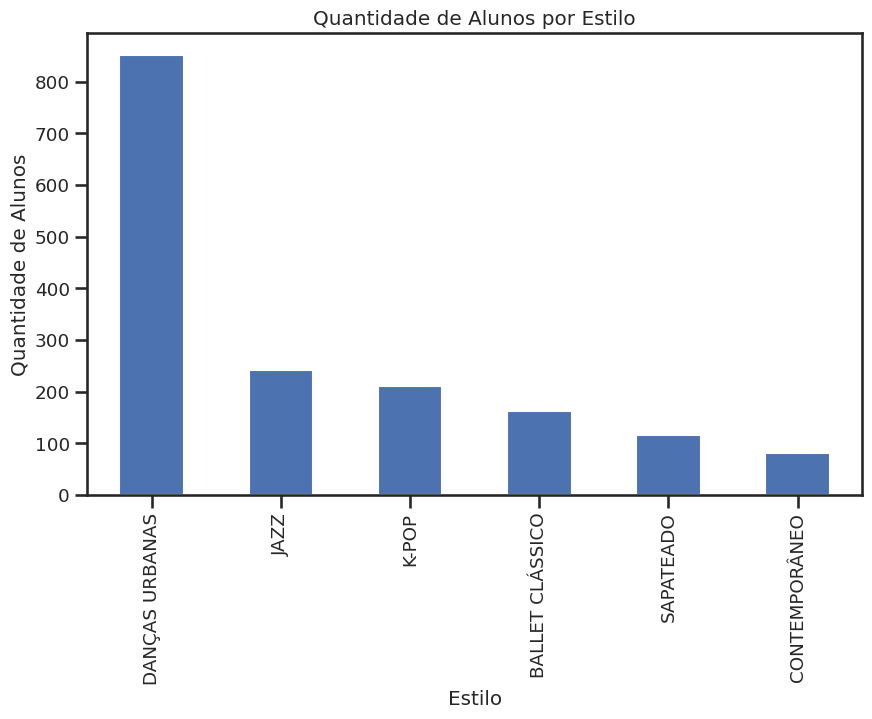

In [60]:
style_counts = df['ESTILOS'].value_counts()

# Plotar o gráfico de barras qtd. alundos x estilos
plt.figure(figsize=(10, 6))
style_counts.plot(kind='bar')
plt.title('Quantidade de Alunos por Estilo')
plt.xlabel('Estilo')
plt.ylabel('Quantidade de Alunos')
plt.show()

In [61]:
# Criar uma tabela de contingência entre as variáveis
contingency_table = pd.crosstab(df['FAIXA ETARIA'], df['ESTILOS'])

In [62]:
# Calcular o valor de Cramer's V (Medida de correlação entre FAIXA ETARIA e ESTILOS, onde 0 é nenhuma correlação e 1 é correlação perfeita)
chi2, p, dof, expected = chi2_contingency(contingency_table)
cramer_v = math.sqrt(chi2 / (df.shape[0] * df.shape[1] * (dof - 1)))

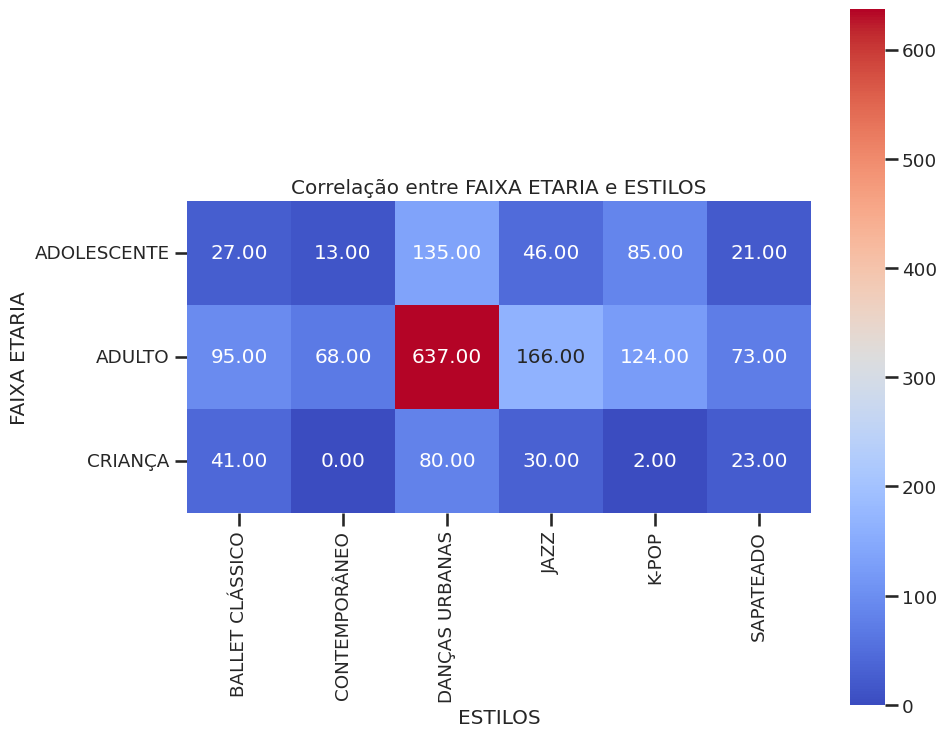

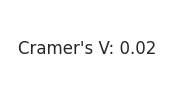

In [63]:
# Plotar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Correlação entre FAIXA ETARIA e ESTILOS')
plt.tight_layout()
plt.show()

plt.figure(figsize=(2, 1))
plt.text(0.5, 0.5, f'Cramer\'s V: {cramer_v:.2f}', ha='center', va='center', fontsize=12)
plt.axis('off')
plt.show() # Cramer's V é 0.3, isso significa que há uma relação moderada entre a faixa etaria dos alunos e estilos de danças

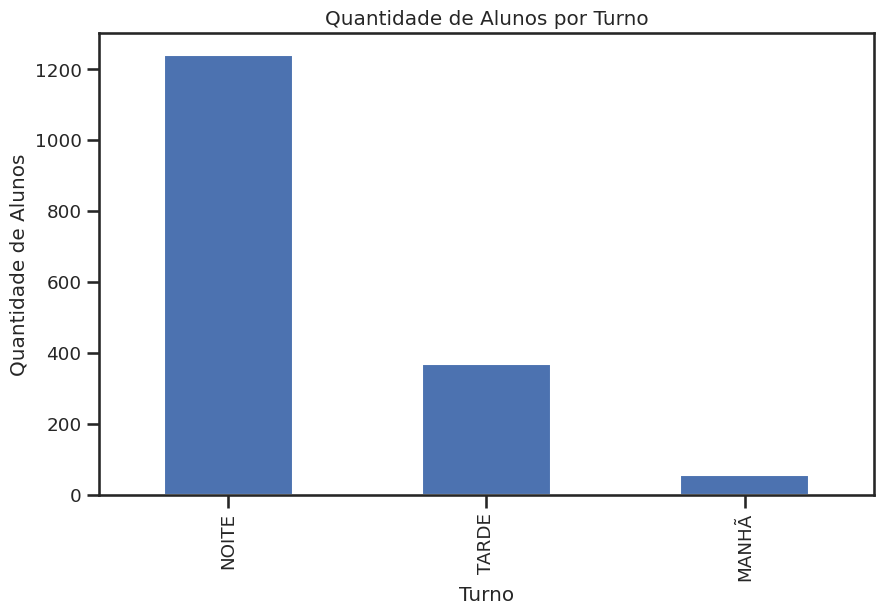

In [64]:
style_countsT = df['TURNO'].value_counts()

plt.figure(figsize=(10, 6))
style_countsT.plot(kind='bar')
plt.title('Quantidade de Alunos por Turno')
plt.xlabel('Turno')
plt.ylabel('Quantidade de Alunos')
plt.show()

In [65]:
contingency_tableT = pd.crosstab(df['TURNO'], df['ESTILOS'])

In [66]:
chi2, p, dof, expected = chi2_contingency(contingency_tableT)
cramer_vT = math.sqrt(chi2 / (df.shape[0] * df.shape[1] * (dof - 1)))

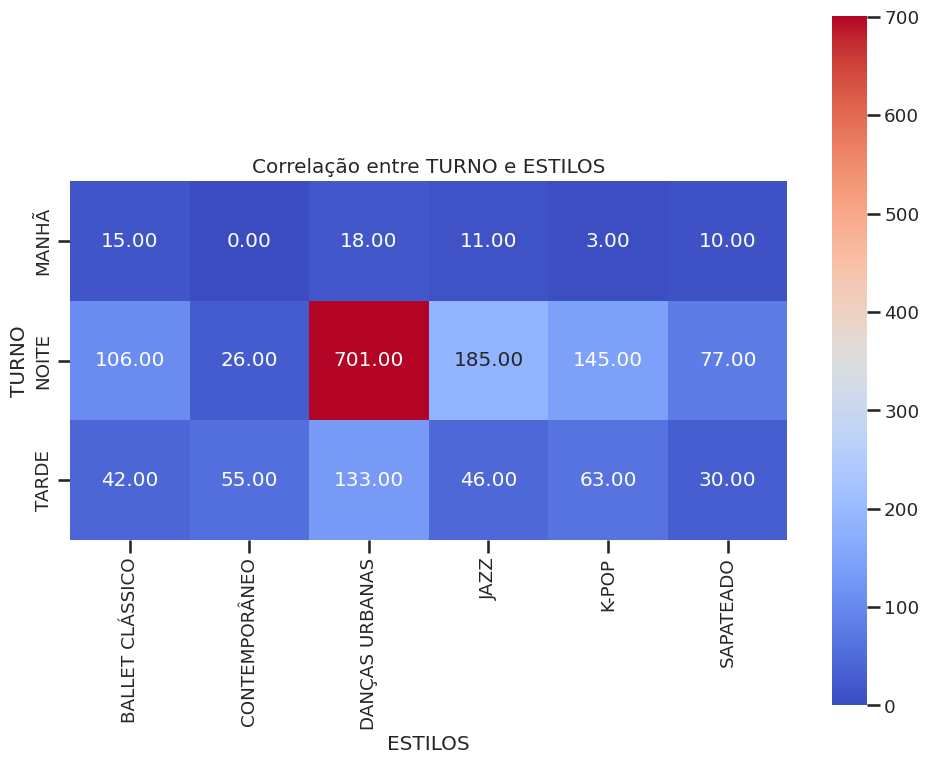

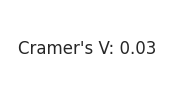

In [67]:
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_tableT, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Correlação entre TURNO e ESTILOS')
plt.tight_layout()
plt.show()

plt.figure(figsize=(2, 1))
plt.text(0.5, 0.5, f'Cramer\'s V: {cramer_vT:.2f}', ha='center', va='center', fontsize=12)
plt.axis('off')
plt.show() # Cramer's V é: 0.02 associação fraca entre as variáveis turno e estilos

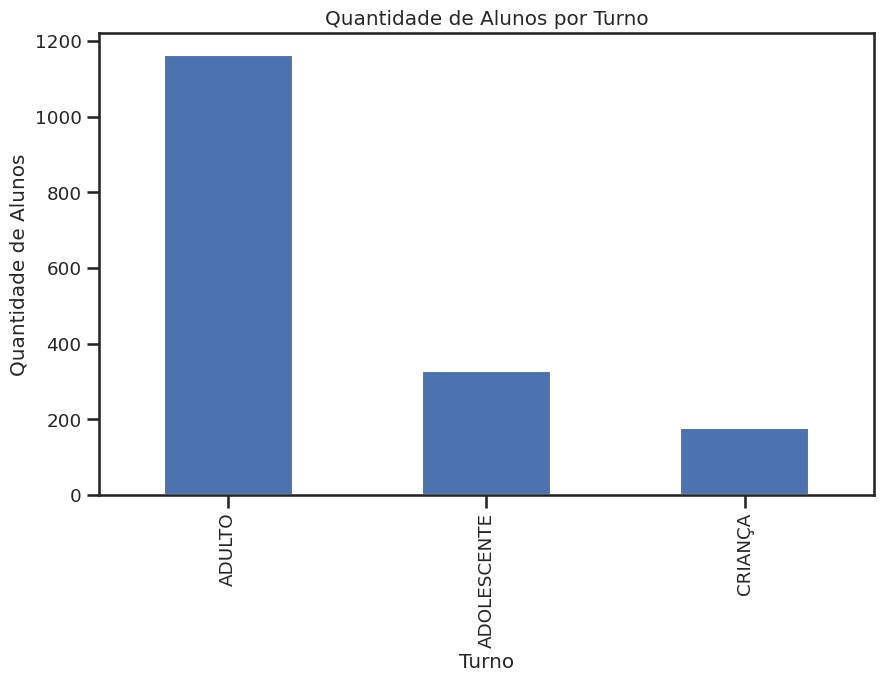

In [68]:
style_countsT = df['FAIXA ETARIA'].value_counts()

plt.figure(figsize=(10, 6))
style_countsT.plot(kind='bar')
plt.title('Quantidade de Alunos por Turno')
plt.xlabel('Turno')
plt.ylabel('Quantidade de Alunos')
plt.show()

In [69]:
df.head(5)

,DATA 1º CONTATO,TRIMESTRE,NOME COMPLETO,IDADE,FAIXA ETARIA,TELEFONE,STATUS,VIA,ESTILOS,DATA AGENDAMENTO,TURNO,PROFESSOR,COMPARECEU,REAGENDAMENTO,SITUAÇÃO,OBSERVAÇÕES,SITUAÇÃO_FINAL
0,2022-01-07,1,GRAZIELE,22,ADULTO,0000-0000,EXPERIMENTAL,WHATSAPP,DANÇAS URBANAS,NaT,NOITE,ALISSON,SIM,NÃO,MATRICULADO,Sem observações,CONTRATADO
1,2022-01-07,1,CAMILA,19,ADULTO,0000-0000,CAPTAÇÃO,WHATSAPP,JAZZ,NaT,NOITE,LIA,NÃO,NÃO,SEMANA SOLIDÁRIA,Sem observações,DESISTIU
2,2021-01-05,1,MAIARA GOUVEA,16,ADULTO,0000-0000,EXPERIMENTAL,WHATS,K-POP,NaT,NOITE,ALISSON,NÃO,NÃO,NÃO RESPONDE,Sem observações,DESISTIU
3,2021-01-05,1,ENIALE RAMOS QUINTINO MÃE ELAINE,11,ADOLESCENTE,0000-0000,EXPERIMENTAL,WHATS,JAZZ,NaT,TARDE,LIA,SIM,NÃO,MATRICULADO,Sem observações,CONTRATADO
4,2022-01-07,1,BIA,19,ADULTO,0000-0000,CAPTAÇÃO,WHATSAPP,DANÇAS URBANAS,NaT,NOITE,NÃO INFORMADO,NÃO,NÃO,SEMANA SOLIDÁRIA,Sem observações,DESISTIU


In [70]:
df['STATUS'].unique()

array(['EXPERIMENTAL', 'CAPTAÇÃO'], dtype=object)

In [71]:
# Convertendo categorias para category
categorias = ['STATUS', 'VIA', 'ESTILOS', 'PROFESSOR', 'COMPARECEU', 'REAGENDAMENTO', 'SITUAÇÃO', 'FAIXA ETARIA', 'TURNO']
for col in categorias:
    df[col] = df[col].astype('category')

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1673
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATA 1º CONTATO   1666 non-null   datetime64[ns]
 1   TRIMESTRE         1666 non-null   int64         
 2   NOME COMPLETO     1666 non-null   object        
 3   IDADE             1666 non-null   int64         
 4   FAIXA ETARIA      1666 non-null   category      
 5   TELEFONE          1666 non-null   object        
 6   STATUS            1666 non-null   category      
 7   VIA               1666 non-null   category      
 8   ESTILOS           1666 non-null   category      
 9   DATA AGENDAMENTO  1666 non-null   object        
 10  TURNO             1666 non-null   category      
 11  PROFESSOR         1666 non-null   category      
 12  COMPARECEU        1666 non-null   category      
 13  REAGENDAMENTO     1666 non-null   category      
 14  SITUAÇÃO          1637 n

<h1><font size="5" color="#FF69B4">Exportação arquivo</font></h1>

<p><font size="4">Exportar o arquivo com as formatações e filtros.</font></p>

In [73]:
# Exportar um arquivo xlsx com as formatações/filtros
# Configurações de formatação
header_format = {
    'bold': True,
    'font_size': 12,
    'align': 'center',
    'valign': 'vcenter',
    'fg_color': '#D3D3D3',
    'border': 1
}

cell_format = {
    'font_size': 11,
    'align': 'center',
    'valign': 'vcenter',
    'border': 1
}

# Crie o objeto ExcelWriter
with pd.ExcelWriter('CRM.xlsx', engine='xlsxwriter') as writer:
    # Exporte o DataFrame para o arquivo xlsx
    df.to_excel(writer, sheet_name='CRM', index=False)

    # Formate a planilha
    workbook = writer.book
    worksheet = writer.sheets['CRM']

    # Adicione o filtro ao cabeçalho
    worksheet.autofilter(0, 0, 0, len(df.columns) - 1)

    # Formatação do cabeçalho
    header_format_obj = workbook.add_format(header_format)
    for col_num, value in enumerate(df.columns.values):
        worksheet.write(0, col_num, value, header_format_obj)

    # Formatação das células
    cell_format_obj = workbook.add_format(cell_format)
    date_format_obj = workbook.add_format({'num_format': 'yyyy-mm-dd', 'border': 1})

    for row_num, row_data in enumerate(df.values):
        for col_num, value in enumerate(row_data):
            if pd.isnull(value):
                worksheet.write(row_num + 1, col_num, '', cell_format_obj)
            elif col_num == 0:
                worksheet.write(row_num + 1, col_num, value, date_format_obj)
            else:
                worksheet.write(row_num + 1, col_num, value, cell_format_obj)

    # Ajuste a largura das colunas
    for col_num, col_width in enumerate([20, 20, 20]):
        worksheet.set_column(col_num, col_num, col_width)

    # Descomente a linha abaixo se você tiver outro DataFrame para exportar
    # df_pc.to_excel(writer, sheet_name='Plano de contas', index=False)

In [74]:
dfC =pd.read_excel('MatriculaCEP.xlsx')

In [75]:
dfC

,Matrícula,Nome,CEP
0,23001,Clara Yumi Shiraishi,12242-431
1,23002,Luisa Mendes Hypolito Neves Pires,12243-710
2,23003,Sofia Mendes Hypolito Neves Pires,12243-710
3,23008,Maria Eduarda Guedes Santos,12231-070
4,23009,Maria Clara Coelho,12242-410
...,...,...,...
86,24030,Henrique Fernandes Veloso,12243-630
87,24031,Priscilla Pereira Figueiredo,12233-002
88,24032,Rafaela Luchi Marques Penteado,12237-410
89,24033,Leticia Akemi Kague,12246-021


In [76]:
# Deixe a coluna "Nome" em caixa alta
dfC['Nome'] = dfC['Nome'].str.upper()

In [77]:
nomes_comuns = dfC['Nome'][dfC['Nome'].isin(df['NOME COMPLETO'])]
nomes_comuns

31         GIOVANNA PEREIRA FLORES
40         MEIRE NAKAMURA YAMAMOTO
45      MARIA RITA BARROS MEDEIROS
53      BENJAMIN PONTE DE OLIVEIRA
55                JOYCE CRUZ PONTE
57        CLARA KRUSCHEWSKY FRANCO
58     MYLENA RODRIGUES GOMES ARÃO
59    ISABELLY CRISTINA REIS SILVA
63             CLARA ARRUDA COELHO
72     ISABELLA IRIE TEIXEIRA REIS
80          ANA CLARA MELO JARONES
Name: Nome, dtype: object

In [78]:
# Encontre os nomes parecidos em ambas as colunas
nomes_parecidos = []
for nome in dfC['Nome']:
    for outro_nome in df['NOME COMPLETO']:
        if fuzz.ratio(nome, outro_nome) > 80:  # ajuste o valor de threshold aqui
            nomes_parecidos.append((nome, outro_nome))
nomes_parecidos

[('SOFIA MENDES HYPOLITO NEVES PIRES',
  'SOFIA MENDES HYPOLITO NEVES PIRES JÁ É ALUNA'),
 ('FERNANDA SAYURI YKEDA', 'FERNANDA SAYURI'),
 ('BEATRIZ SCHIMIDT BARONI', 'BEATRIZ SCHIMIDT BARONI JÁ É ALUNA'),
 ('ANA CLARA RAMOS CASIMIRO', 'ANA CLARA RAMOS CASEMIRO'),
 ('GIOVANNA PEREIRA FLORES', 'GIOVANNA PEREIRA FLORES'),
 ('VANESSA DE ALMEIDA VITÓRIA', 'VANESSA DE ALMEIDA VITORIA'),
 ('THALITA DIAS FERREIRA', 'TALITHA MORAES FERREIRA'),
 ('MEIRE NAKAMURA YAMAMOTO', 'MEIRE NAKAMURA YAMAMOTO'),
 ('MARIA RITA BARROS MEDEIROS', 'MARIA RITA BARROS MEDEIROS'),
 ('MARIA RITA BARROS MEDEIROS', 'MARIA RITA BARROS MEDEIROS'),
 ('MARIA RITA BARROS MEDEIROS', 'MARIA RITA BARROS MEDEIROS'),
 ('MANUELA NASCIMENTO DE ARAÚJO', 'MANUELA NASCIMENTO MÃE RENATA'),
 ('ELIS HELENA CRUZ PUNTO DE OLIVEIRA', 'ELIS HELENA CRUZ PONTE DE OLIVEIRA'),
 ('BENJAMIN PONTE DE OLIVEIRA', 'BENJAMIN PONTE DE OLIVEIRA'),
 ('JOYCE CRUZ PONTE', 'JOYCE CRUZ PONTE'),
 ('CLARA KRUSCHEWSKY FRANCO', 'CLARA KRUSCHEWSKY FRANCO'),
 ('

In [79]:
nomes_parecidos = pd.Series(nomes_parecidos)
nomes_parecidos.value_counts()

(ALINE DE FÁTIMA DE CARVALHO VIEIRA, ALINE DE FATIMA DE CARVALHO VIEIRA)             4
(ISABELLA IRIE TEIXEIRA REIS, ISABELLA IRIE TEIXEIRA REIS)                           3
(MARIA RITA BARROS MEDEIROS, MARIA RITA BARROS MEDEIROS)                             3
(CLARA ARRUDA COELHO, CLARA ARRUDA COELHO)                                           2
(AMANDA VENEGAS DOS ANJOS, AMANDA VENEGAS DOS ANJOS CASSIANA)                        2
(SOFIA MENDES HYPOLITO NEVES PIRES, SOFIA MENDES HYPOLITO NEVES PIRES JÁ É ALUNA)    1
(JOYCE CRUZ PONTE, JOYCE CRUZ PONTE)                                                 1
(YASMIN CHU ALVES DA SILVA, YASMIN CHU ALVES DA SILVA MÃE CHU)                       1
(MARIA EDUARDA DA ROSA VIEIRA, MARIA EDUARDA DA ROSA)                                1
(ISABELLY CRISTINA REIS SILVA, ISABELLY CRISTINA REIS SILVA)                         1
(MYLENA RODRIGUES GOMES ARÃO, MYLENA RODRIGUES GOMES ARÃO)                           1
(CLARA KRUSCHEWSKY FRANCO, CLARA KRUSCHEWSK

In [80]:
# Ler o arquivo PDF com configurações de leitura ajustadas
ReceitaSet23 = tabula.read_pdf('Relatório de receitas - Set 23.pdf', pages='all',
                              guess=False,
                              lattice=True,
                              stream=True,
                              multiple_tables=True,
                              pandas_options={'header': None,
                                              'parse_dates': False})

# Substitua os valores vazios por NaN
ReceitaSet23 = ReceitaSet23.replace('', pd.NA)

FileNotFoundError: [Errno 2] No such file or directory: 'Relatório de receitas - Set 23.pdf'